# Simplified dynamical models

This notebook illustrates how to set up and integrate dynamical models that include certain resonant interactions between the planets using celmech, as discussed at length in [Lammers et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240317928L/abstract). First, we specify the initial conditions using a REBOUND simulation, which we use to initialize a PoincareHamiltonian object. Then, we generate the corresponding equations of motion and numerically integrate them, monitoring for close encouters between the planets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import rebound as rb
from celmech import Poincare, PoincareHamiltonian

# Simulation setups

In [2]:
# get REBOUND simulation of idealized system (coplanar, equal spacings, masses, and eccentricites)
def initialize_sim(P_ratio, P1=0.0316, m=3e-6, e_norm=0.0, Npl=5):
    # calculate eccentricity
    e_cross = (P_ratio**(2/3) - 1)/(1 + P_ratio**(2/3))
    e = e_norm*e_cross
    
    # setup sim object
    sim = rb.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=1.00)
    
    # add planets
    for i in range(Npl):
        sim.add(m=m, P=P1*(P_ratio**i), e=e, pomega=np.random.uniform(0.0, 2*np.pi), l=np.random.uniform(0.0, 2*np.pi))
    sim.move_to_com()
    
    return sim

In [3]:
# get PoincareHamiltonian that includes a specific set of MMRs
def construct_Hamiltonian(sim, res_indices):
    # initialize Hamiltonian
    pvars = Poincare.from_Simulation(sim)
    pham = PoincareHamiltonian(pvars)
    
    # add resonances
    for (j, k, ind_pl1, ind_pl2) in res_indices:
        pham.add_MMR_terms(j, k, max_order=k, indexIn=ind_pl1, indexOut=ind_pl2, inclinations=False)
    
    # set integration settings
    pham._update()
    pham.set_integrator('dop853', nsteps=int(1e9), atol=1e-100, rtol=1e-5)
    
    return pham

In [4]:
# numerically integrate PoincareHamiltonian model to predict the system's instability time
def predict_t_inst(pham, t_max=1e4):
    # determine minimum stopping distance
    ps = pham.state.particles
    stopping_dist = ps[1].a*(ps[1].m**(1/3))
    Npl = len(ps) - 1
    P1 = ps[1].P
    
    # integrate
    times = np.logspace(0.0, np.log10(t_max), 10000)*P1
    for t in times:
        pham.integrate(t)
        
        for i in range(1, Npl):
            if (1 - ps[i+1].e)*ps[i+1].a - (1 + ps[i].e)*ps[i].a < stopping_dist:
                return pham.t/P1
        
    return t_max

# Model (1)

In [5]:
P_ratios = []
log_t_insts = []

# predict instability times for 25 systems
for _ in tqdm(range(25)):
    P_ratio = np.random.uniform(1.03, 1.11)
    sim = initialize_sim(P_ratio)
    
    j = int(np.round(1/(1 - 1/P_ratio))) # get index of nearest first-order MMR
    res_inds = [[j, 1, i, i+1] for i in range(1, 5)] # all resonances to be included
    
    pham = construct_Hamiltonian(sim, res_inds)
    t_inst = predict_t_inst(pham)
    
    P_ratios.append(P_ratio)
    log_t_insts.append(np.log10(t_inst))

100%|████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:37<00:00,  6.31s/it]


(-0.4, 4.5)

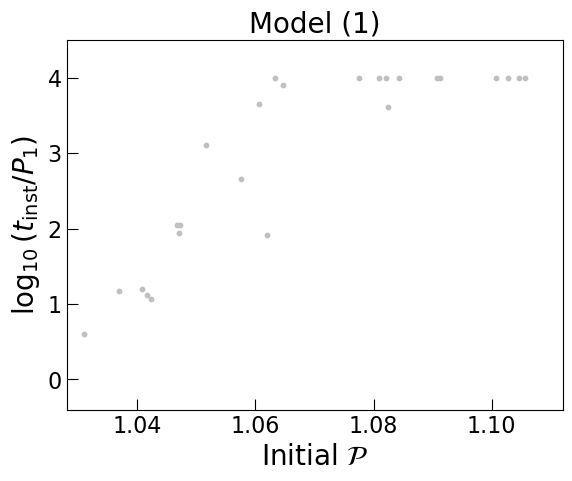

In [6]:
# plot
plt.scatter(P_ratios, log_t_insts, c='silver', s=10)
plt.tick_params(labelsize=16,size=8,direction='in')
plt.xlabel(r'Initial $\mathcal{P}$', fontsize=20)
plt.ylabel(r'$\log_{10}(t_\mathrm{inst}/P_1)$', fontsize=20)
plt.title(r'Model (1)', fontsize=20)
plt.xlim([1.028, 1.112])
plt.ylim([-0.4, 4.5])

Model (1) predicts that most widely-spaced systems will survive for the full integration time. Increasing the number of systems and/or the maximum integration time requires computational resources (or a great deal of patience).

# Model (2)

In [7]:
P_ratios = []
log_t_insts = []

# predict instability times for 25 systems
for _ in tqdm(range(25)):
    P_ratio = np.random.uniform(1.03, 1.11)
    sim = initialize_sim(P_ratio)
    
    # get indices of bordering first-order MMRs
    j1 = int(np.floor(1/(1 - 1/P_ratio)))
    j2 = int(np.ceil(1/(1 - 1/P_ratio)))
    
    res_inds1 = [[j1, 1, i, i+1] for i in range(1, 5)] # all j1 resonances
    res_inds2 = [[j2, 1, i, i+1] for i in range(1, 5)] # all j2 resonances
    
    pham = construct_Hamiltonian(sim, res_inds1 + res_inds2)
    t_inst = predict_t_inst(pham)
    
    P_ratios.append(P_ratio)
    log_t_insts.append(np.log10(t_inst))

100%|████████████████████████████████████████████████████████████████████████████████████| 25/25 [04:01<00:00,  9.66s/it]


(-0.4, 4.5)

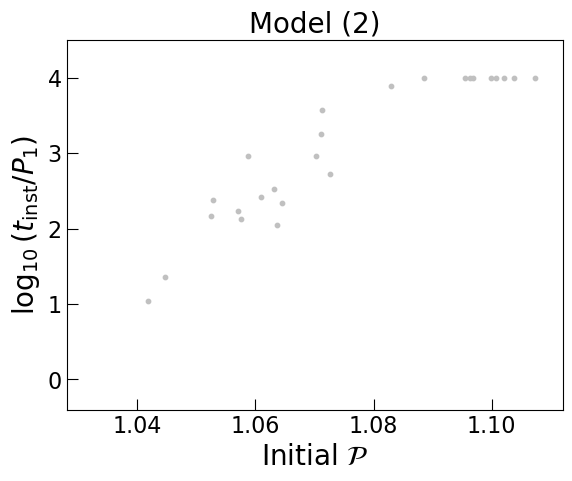

In [8]:
# plot
plt.scatter(P_ratios, log_t_insts, c='silver', s=10)
plt.tick_params(labelsize=16,size=8,direction='in')
plt.xlabel(r'Initial $\mathcal{P}$', fontsize=20)
plt.ylabel(r'$\log_{10}(t_\mathrm{inst}/P_1)$', fontsize=20)
plt.title(r'Model (2)', fontsize=20)
plt.xlim([1.028, 1.112])
plt.ylim([-0.4, 4.5])

Model (2) already appears to do a better job at predicting instability times. To determine exactly how accurate the predictions of the model are, one can compare with true instability times from full $N$-body simulations (see Figs. 4-9 in the paper).

# Model (2, 1)

In [9]:
P_ratios = []
log_t_insts = []

# predict instability times for 25 systems
for _ in tqdm(range(25)):
    P_ratio = np.random.uniform(1.03, 1.11)
    sim = initialize_sim(P_ratio)
    
    # get indices of bordering first-order MMRs
    j1 = int(np.floor(1/(1 - 1/P_ratio)))
    j2 = int(np.ceil(1/(1 - 1/P_ratio)))
    j3 = j1 + j2 #second-order MMR that lies between the first-order MMRs
    
    res_inds1 = [[j1, 1, i, i+1] for i in range(1, 5)] # all j1 resonances
    res_inds2 = [[j2, 1, i, i+1] for i in range(1, 5)] # all j2 resonances
    res_inds3 = [[j3, 2, i, i+1] for i in range(1, 5)] # all j3 resonances
    
    pham = construct_Hamiltonian(sim, res_inds1 + res_inds2 + res_inds3)
    t_inst = predict_t_inst(pham)
    
    P_ratios.append(P_ratio)
    log_t_insts.append(np.log10(t_inst))

100%|████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:04<00:00, 16.99s/it]


(-0.4, 4.5)

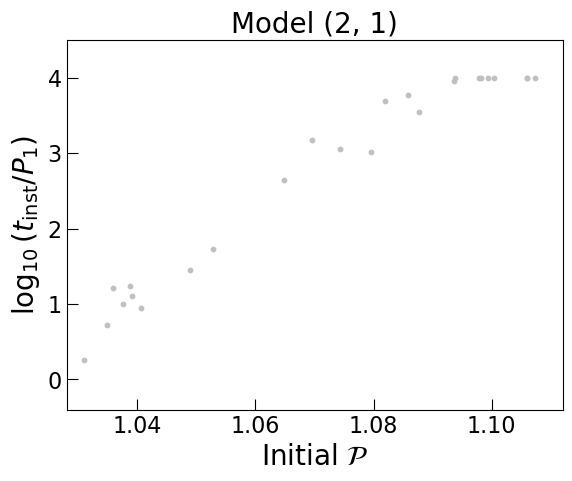

In [10]:
# plot
plt.scatter(P_ratios, log_t_insts, c='silver', s=10)
plt.tick_params(labelsize=16,size=8,direction='in')
plt.xlabel(r'Initial $\mathcal{P}$', fontsize=20)
plt.ylabel(r'$\log_{10}(t_\mathrm{inst}/P_1)$', fontsize=20)
plt.title(r'Model (2, 1)', fontsize=20)
plt.xlim([1.028, 1.112])
plt.ylim([-0.4, 4.5])

Extending beyond Model (2, 1) to include higher-order MMRs can be done by simply adding the indices of the desired resonances to `res_inds`. Secular terms can be added to the Hamiltonian models using `pham.add_secular_terms`.